In [10]:
import pandas as pd
from PIL import Image
import albumentations as A
import torch
from torch import nn
from torchvision.models import resnet18, resnet34, inception_v3, efficientnet_b0, efficientnet_b4
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

import os
import warnings


warnings.filterwarnings('ignore')

In [11]:
class Config:

    train_image_files_path = './train/'
    test_image_files_path = './test/'
    sub_image_files = './example.csv'

In [12]:
train_files_path_list = os.listdir(Config.train_image_files_path)[1:]
train_files_list = []

for files_type in train_files_path_list:
    files_type_path = os.path.join(Config.train_image_files_path, files_type)
    for files in os.listdir(files_type_path):
        train_files_list.append([files_type, os.path.join(files_type_path, files)])


test_files_list = list(map(lambda x:os.path.join(Config.test_image_files_path, x), os.listdir(Config.test_image_files_path)))

In [23]:
len(test_files_list)

200

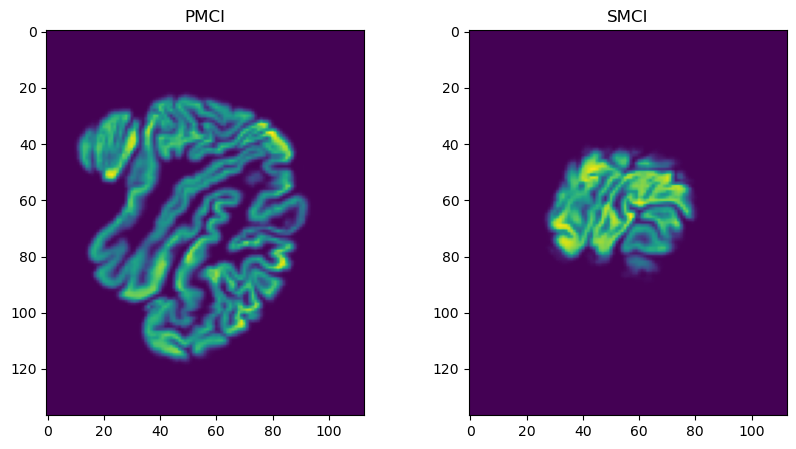

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

axes = ax.flatten()

image_1 = Image.open('./train/PMCI/128_S_1407_24.png')
image_2 = Image.open('./train/SMCI/002_S_1155_12.png')

axes[0].imshow(image_1)
axes[1].imshow(image_2)

axes[0].set_title('PMCI')
axes[1].set_title('SMCI')

plt.show()

In [6]:
import numpy as np

class MyDataset(Dataset):
    
    def __init__(self, file_list, transformer, data_type) -> None:
        super(MyDataset, self).__init__()
        self.file_list = file_list
        self.transformer = transformer
        self.data_type = data_type

    def _preprocess_first(self, img_file):
        image = Image.open(img_file)
        img = image.convert('RGB')

        img_np = np.array(img)
        index_img = np.where(img_np>50)

        x = index_img[0]
        y = index_img[1]

        max_x = max(x)
        min_x = min(x)
        max_y = max(y)
        min_y = min(y)

        max_x = max_x + 10
        min_x = min_x - 10
        max_y = max_y + 10
        min_y = min_y - 10

        if max_x > img_np.shape[0]:
            max_x = img_np.shape[0]

        if min_x < 0:
            min_x = 0
        if max_y > img_np.shape[1]:
            max_y = img_np.shape[1]
        if min_y < 0:
            min_y = 0

        img_new = img_np[min_x:max_x, min_y:max_y, :]
        
        return img_new

    def _preprocess_secondg(self, img_array):
        length_1 = img_array.shape[0]
        length_2 = img_array.shape[1]

        max_lenght = max(length_1, length_2)

        result_1 = (max_lenght - length_1) // 2
        result_2 = (max_lenght - length_2) // 2

        if (max_lenght - length_1) % 2 != 0:
            result_1 += 1

        if (max_lenght - length_2) % 2 != 0:
            result_2 += 1

        new_img_change = np.pad(img_array, ((result_1, result_1), 
                                            (result_2, result_2),
                                            (0, 0)), mode='constant')
        return new_img_change

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file_path = self.file_list[idx]

        image_file = file_path[1]
        image_label = file_path[0]

        # image = Image.open(image_file)
        # image = image.convert('RGB') 
        # image = np.array(image).astype(np.float64)
        image = self._preprocess_first(image_file)
        image = self._preprocess_secondg(image)
        
        
        image = self.transformer(image=image)['image']
        img = image.transpose([2, 0, 1])

        if (self.data_type == 'train') or (self.data_type=='val'):
            return img, torch.from_numpy(np.array(int('PMCI' in image_label)))
        else:
            return img
        
transformer = A.Compose([A.RandomRotate90(),
                        A.Resize(299, 299),
                        A.HorizontalFlip(p=0.5),
                        # A.RandomBrightnessContrast(p=0.5),
                        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                        ])

testsformer = A.Compose([A.Resize(299, 299),
                        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                        ])

In [7]:
import torch.optim as optim

class MyNet(nn.Module):

    def __init__(self, num_classes):
        super(MyNet, self).__init__()
        
        model_1 = efficientnet_b4(True)
        model_1.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1792, num_classes)
        )
        self.model_1 = model_1

        # model_2 = resnet34(True)
        # model_2.fc = nn.Linear(512, num_classes)
        # self.model_2 = model_2

        # self.fc = nn.Linear(num_classes*2, num_classes)

    def forward(self, x):
        x = self.model_1(x)
        # x2 = self.model_2(x)

        # output_ = torch.cat((x1, x2), dim=1)
        # output_ = self.fc(output_)
        return x
    
model = MyNet(2)

params_with_custom_lr = []
params_with_default_lr = []

for name, params in model.named_parameters():
    if 'fc' not in name:
        params_with_default_lr.append(params)
    else:
        params_with_custom_lr.append(params)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)
# optimizer = optim.Adam([{'params': params_with_default_lr}, 
#                         {'params': params_with_custom_lr, 'lr':0.01}], lr=0.001)

In [8]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(image)
        l = criterion(output, label)
        l.backward()
        optimizer.step()
        train_loss += l.item() * image.shape[0]
    train_loss = train_loss / len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


def val(val_loader, model, criterion, epoch):
    model.eval()
    val_loss = 0
    gt_label = []
    pred_label = []
    with torch.no_grad():
        for image, label in val_loader:
            output = model(image)
            l = criterion(output, label)
            pred = torch.argmax(output, 1)
            gt_label.append(label)
            pred_label.append(pred)
            val_loss += l.item() * image.shape[0]
        val_loss = val_loss / len(val_loader)
        gt_labels, pred_labels = np.concatenate(gt_label), np.concatenate(pred_label)
        acc = np.sum(gt_labels==pred_labels) / len(gt_labels)
        print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))
    return acc

In [9]:
from tqdm import tqdm
import random

random.shuffle(train_files_list)
    
trainloader = DataLoader(MyDataset(train_files_list[:300], transformer, data_type='train'), batch_size=16, shuffle=True)
valloader = DataLoader(MyDataset(train_files_list[300:], transformer, data_type='train'), batch_size=2, shuffle=False)
testloader = DataLoader(MyDataset(test_files_list, testsformer, data_type='test'), batch_size=2, shuffle=False)

for epoch in tqdm(range(1, 50+1), desc='Training'):
    train(trainloader,  model, loss, optimizer, epoch)
    val(valloader, model, loss, epoch)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 10.597336


Training:   2%|▏         | 1/50 [07:10<5:51:19, 430.20s/it]

Epoch: 1 	Validation Loss: 1.402879, Accuracy: 0.530000
Epoch: 2 	Training Loss: 9.706009


Training:   4%|▍         | 2/50 [14:15<5:42:05, 427.61s/it]

Epoch: 2 	Validation Loss: 1.417981, Accuracy: 0.590000
Epoch: 3 	Training Loss: 8.575013


Training:   6%|▌         | 3/50 [21:09<5:29:57, 421.23s/it]

Epoch: 3 	Validation Loss: 1.638280, Accuracy: 0.600000
Epoch: 4 	Training Loss: 7.352510


Training:   8%|▊         | 4/50 [27:57<5:18:44, 415.76s/it]

Epoch: 4 	Validation Loss: 1.263705, Accuracy: 0.670000
Epoch: 5 	Training Loss: 5.435773


Training:  10%|█         | 5/50 [34:45<5:09:53, 413.19s/it]

Epoch: 5 	Validation Loss: 1.562792, Accuracy: 0.610000
Epoch: 6 	Training Loss: 5.490734


Training:  12%|█▏        | 6/50 [41:30<5:01:01, 410.50s/it]

Epoch: 6 	Validation Loss: 1.603149, Accuracy: 0.730000
Epoch: 7 	Training Loss: 5.494173


Training:  14%|█▍        | 7/50 [48:20<4:54:02, 410.30s/it]

Epoch: 7 	Validation Loss: 1.862999, Accuracy: 0.720000
Epoch: 8 	Training Loss: 4.344949


Training:  16%|█▌        | 8/50 [55:07<4:46:21, 409.08s/it]

Epoch: 8 	Validation Loss: 2.482148, Accuracy: 0.610000
Epoch: 9 	Training Loss: 6.111611


Training:  18%|█▊        | 9/50 [1:01:56<4:39:39, 409.26s/it]

Epoch: 9 	Validation Loss: 1.432951, Accuracy: 0.650000
Epoch: 10 	Training Loss: 3.946899


Training:  20%|██        | 10/50 [1:08:46<4:32:49, 409.23s/it]

Epoch: 10 	Validation Loss: 1.845933, Accuracy: 0.680000
Epoch: 11 	Training Loss: 3.074196


Training:  22%|██▏       | 11/50 [1:15:35<4:26:02, 409.30s/it]

Epoch: 11 	Validation Loss: 2.361748, Accuracy: 0.620000
Epoch: 12 	Training Loss: 2.287753


Training:  24%|██▍       | 12/50 [1:22:25<4:19:26, 409.64s/it]

Epoch: 12 	Validation Loss: 2.174519, Accuracy: 0.670000
Epoch: 13 	Training Loss: 3.475720


Training:  26%|██▌       | 13/50 [1:29:13<4:12:10, 408.92s/it]

Epoch: 13 	Validation Loss: 2.538080, Accuracy: 0.590000
Epoch: 14 	Training Loss: 4.016490


Training:  28%|██▊       | 14/50 [1:36:01<4:05:14, 408.73s/it]

Epoch: 14 	Validation Loss: 1.653474, Accuracy: 0.650000
Epoch: 15 	Training Loss: 3.406638


Training:  30%|███       | 15/50 [1:42:50<3:58:30, 408.87s/it]

Epoch: 15 	Validation Loss: 2.144652, Accuracy: 0.690000
Epoch: 16 	Training Loss: 2.344814


Training:  32%|███▏      | 16/50 [1:49:37<3:51:20, 408.26s/it]

Epoch: 16 	Validation Loss: 1.747995, Accuracy: 0.690000
Epoch: 17 	Training Loss: 2.892356


Training:  34%|███▍      | 17/50 [1:56:25<3:44:30, 408.20s/it]

Epoch: 17 	Validation Loss: 1.292918, Accuracy: 0.720000
Epoch: 18 	Training Loss: 2.298771


Training:  36%|███▌      | 18/50 [2:03:15<3:38:00, 408.76s/it]

Epoch: 18 	Validation Loss: 1.981627, Accuracy: 0.660000
Epoch: 19 	Training Loss: 1.561744


Training:  38%|███▊      | 19/50 [2:10:05<3:31:23, 409.14s/it]

Epoch: 19 	Validation Loss: 1.894668, Accuracy: 0.690000
Epoch: 20 	Training Loss: 2.022687


Training:  40%|████      | 20/50 [2:16:55<3:24:41, 409.37s/it]

Epoch: 20 	Validation Loss: 1.768463, Accuracy: 0.700000
Epoch: 21 	Training Loss: 2.825965


Training:  42%|████▏     | 21/50 [2:23:45<3:17:53, 409.43s/it]

Epoch: 21 	Validation Loss: 2.766199, Accuracy: 0.630000
Epoch: 22 	Training Loss: 2.381904


Training:  44%|████▍     | 22/50 [2:30:35<3:11:11, 409.70s/it]

Epoch: 22 	Validation Loss: 1.784299, Accuracy: 0.690000
Epoch: 23 	Training Loss: 1.463984


Training:  46%|████▌     | 23/50 [2:37:24<3:04:20, 409.63s/it]

Epoch: 23 	Validation Loss: 2.397179, Accuracy: 0.680000
Epoch: 24 	Training Loss: 1.651317


Training:  48%|████▊     | 24/50 [2:44:14<2:57:31, 409.69s/it]

Epoch: 24 	Validation Loss: 2.907153, Accuracy: 0.650000
Epoch: 25 	Training Loss: 1.692813


Training:  50%|█████     | 25/50 [2:51:04<2:50:44, 409.78s/it]

Epoch: 25 	Validation Loss: 1.887240, Accuracy: 0.730000
Epoch: 26 	Training Loss: 2.052342


Training:  52%|█████▏    | 26/50 [2:57:52<2:43:41, 409.24s/it]

Epoch: 26 	Validation Loss: 2.361709, Accuracy: 0.670000
Epoch: 27 	Training Loss: 1.175892


Training:  54%|█████▍    | 27/50 [3:04:40<2:36:44, 408.90s/it]

Epoch: 27 	Validation Loss: 2.677526, Accuracy: 0.640000
Epoch: 28 	Training Loss: 1.494055


Training:  56%|█████▌    | 28/50 [3:11:31<2:30:04, 409.29s/it]

Epoch: 28 	Validation Loss: 1.908575, Accuracy: 0.660000
Epoch: 29 	Training Loss: 1.690525


Training:  58%|█████▊    | 29/50 [3:18:20<2:23:16, 409.37s/it]

Epoch: 29 	Validation Loss: 1.917367, Accuracy: 0.720000
Epoch: 30 	Training Loss: 1.103306


Training:  60%|██████    | 30/50 [3:25:10<2:16:31, 409.60s/it]

Epoch: 30 	Validation Loss: 3.139555, Accuracy: 0.670000
Epoch: 31 	Training Loss: 1.048871


Training:  62%|██████▏   | 31/50 [3:32:00<2:09:43, 409.67s/it]

Epoch: 31 	Validation Loss: 3.203969, Accuracy: 0.710000
Epoch: 32 	Training Loss: 1.970829


Training:  64%|██████▍   | 32/50 [3:38:49<2:02:48, 409.38s/it]

Epoch: 32 	Validation Loss: 1.871715, Accuracy: 0.620000
Epoch: 33 	Training Loss: 1.895468


Training:  66%|██████▌   | 33/50 [3:45:28<1:55:09, 406.47s/it]

Epoch: 33 	Validation Loss: 2.953847, Accuracy: 0.610000
Epoch: 34 	Training Loss: 1.220910


Training:  68%|██████▊   | 34/50 [3:52:06<1:47:42, 403.89s/it]

Epoch: 34 	Validation Loss: 1.998187, Accuracy: 0.690000
Epoch: 35 	Training Loss: 0.948989


Training:  70%|███████   | 35/50 [3:58:50<1:40:59, 403.95s/it]

Epoch: 35 	Validation Loss: 2.696498, Accuracy: 0.700000
Epoch: 36 	Training Loss: 0.898030


Training:  72%|███████▏  | 36/50 [4:05:30<1:33:58, 402.74s/it]

Epoch: 36 	Validation Loss: 2.356565, Accuracy: 0.710000
Epoch: 37 	Training Loss: 1.060318


Training:  74%|███████▍  | 37/50 [4:12:17<1:27:30, 403.90s/it]

Epoch: 37 	Validation Loss: 3.325424, Accuracy: 0.660000
Epoch: 38 	Training Loss: 1.567690


Training:  76%|███████▌  | 38/50 [4:18:57<1:20:34, 402.87s/it]

Epoch: 38 	Validation Loss: 2.475977, Accuracy: 0.660000
Epoch: 39 	Training Loss: 1.259361


Training:  78%|███████▊  | 39/50 [4:25:47<1:14:13, 404.84s/it]

Epoch: 39 	Validation Loss: 2.374558, Accuracy: 0.650000
Epoch: 40 	Training Loss: 0.734141


Training:  80%|████████  | 40/50 [4:32:32<1:07:30, 405.04s/it]

Epoch: 40 	Validation Loss: 3.017800, Accuracy: 0.730000
Epoch: 41 	Training Loss: 0.823858


Training:  82%|████████▏ | 41/50 [4:39:20<1:00:53, 405.90s/it]

Epoch: 41 	Validation Loss: 2.770389, Accuracy: 0.700000
Epoch: 42 	Training Loss: 0.577374


Training:  84%|████████▍ | 42/50 [4:46:09<54:14, 406.86s/it]  

Epoch: 42 	Validation Loss: 2.328860, Accuracy: 0.750000
Epoch: 43 	Training Loss: 0.789648


Training:  86%|████████▌ | 43/50 [4:52:57<47:30, 407.22s/it]

Epoch: 43 	Validation Loss: 4.533297, Accuracy: 0.680000
Epoch: 44 	Training Loss: 0.393201


Training:  88%|████████▊ | 44/50 [4:59:47<40:47, 407.88s/it]

Epoch: 44 	Validation Loss: 3.333762, Accuracy: 0.750000
Epoch: 45 	Training Loss: 0.858051


Training:  90%|█████████ | 45/50 [5:06:36<34:01, 408.38s/it]

Epoch: 45 	Validation Loss: 2.628029, Accuracy: 0.730000
Epoch: 46 	Training Loss: 0.206040


Training:  92%|█████████▏| 46/50 [5:13:26<27:15, 408.84s/it]

Epoch: 46 	Validation Loss: 3.010674, Accuracy: 0.690000
Epoch: 47 	Training Loss: 1.138926


Training:  94%|█████████▍| 47/50 [5:20:14<20:25, 408.58s/it]

Epoch: 47 	Validation Loss: 3.357815, Accuracy: 0.690000
Epoch: 48 	Training Loss: 0.512847


Training:  96%|█████████▌| 48/50 [5:27:04<13:37, 408.96s/it]

Epoch: 48 	Validation Loss: 2.629407, Accuracy: 0.710000
Epoch: 49 	Training Loss: 0.286989


Training:  98%|█████████▊| 49/50 [5:33:53<06:49, 409.04s/it]

Epoch: 49 	Validation Loss: 2.283821, Accuracy: 0.770000
Epoch: 50 	Training Loss: 0.678850


Training: 100%|██████████| 50/50 [5:40:44<00:00, 408.89s/it]

Epoch: 50 	Validation Loss: 2.180669, Accuracy: 0.760000


In [11]:
from sklearn.model_selection import KFold

n_split = 5
seed = 2024

kf = KFold(n_splits=n_split, shuffle=True, random_state=seed)

for i, (train_index, val_index) in enumerate(kf.split(train_files_list, train_files_list)):
    trainloader = DataLoader(MyDataset(train_files_list[train_index], transformer, data_type='train'), batch_size=16, shuffle=True)
    valloader = DataLoader(MyDataset(train_files_list[val_index], transformer, data_type='val'), batch_size=2, shuffle=False)

    model = MyNet(2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 0.001)

    all_loss = []
    for epoch in range(1, 50+1):
        loss = train(trainloader, model, criterion, optimizer, epoch)
        all_loss.append(loss)
        val_acc = val(valloader, model, criterion, epoch)
        if val_acc.avg.item() >= best_acc:
            best_acc = val_acc.avg.item()
            torch.save(model.state_dict(), args.save_dir + '/best_acc_dogenet_b8' + args.v + '.pth')

0 [  0   1   3   4   6   7   8  10  11  12  13  14  16  17  18  19  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  36  37  39  40  41  42
  43  44  45  47  48  49  50  51  52  53  54  55  57  58  59  60  61  62
  63  64  65  66  67  68  69  71  72  73  74  76  77  78  79  80  81  82
  83  84  86  87  89  90  91  93  94  95  96  97  99 100 101 102 104 105
 106 107 109 110 111 112 114 116 117 118 119 120 121 122 123 124 127 128
 129 130 135 136 139 140 141 142 143 144 146 147 148 150 152 153 154 157
 158 160 161 162 163 164 165 166 167 168 169 170 171 173 175 176 178 179
 181 183 185 186 187 188 189 190 191 192 193 194 196 198 199 200 202 204
 205 206 207 211 212 213 214 215 217 218 219 220 221 222 224 225 227 228
 229 230 231 232 233 234 235 237 238 239 241 242 243 244 245 246 247 248
 249 250 252 253 254 255 257 258 259 260 261 262 263 265 266 267 268 269
 270 271 272 273 274 275 277 278 279 280 281 282 283 284 285 286 287 288
 290 291 292 294 295 296 297 298 299 301 302 303 

In [32]:
torch.save(model.state_dict(), './efficientnet_b4_0625.pth')

In [33]:
import torch

model_done = torch.load('./efficientnet_b4_0625.pth')

class MyNet(nn.Module):

    def __init__(self, num_classes):
        super(MyNet, self).__init__()
        
        model_1 = efficientnet_b4()
        model_1.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1792, num_classes)
        )
        self.model_1 = model_1

    def forward(self, x):
        x = self.model_1(x)
        return x
    
model_0617 = MyNet(2)
model_0617.load_state_dict(model_done)

<All keys matched successfully>

In [35]:
y_pred_list = []
y_true_list = []

for (image, label) in tqdm(valloader):
    with torch.no_grad():
        model_0617.eval()
        y_pred = model_0617(image)
        y_pred_list.append(torch.argmax(y_pred, 1))
        y_true_list.append(label)

100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


In [36]:
from sklearn.metrics import f1_score

y_pred_list_ = np.concatenate(y_pred_list)
y_true_list_ = np.concatenate(y_true_list)


f1_score(y_true_list_, y_pred_list_)

0.74

Text(0.5, 1.0, 'New')

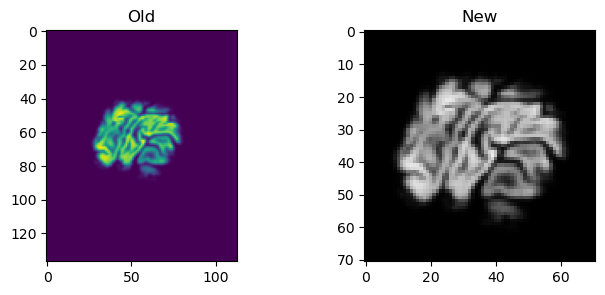

In [31]:
def _preprocess_first(img_file):
    image = Image.open(img_file)
    img = image.convert('RGB')

    img_np = np.array(img)
    index_img = np.where(img_np>50)

    x = index_img[0]
    y = index_img[1]

    max_x = max(x)
    min_x = min(x)
    max_y = max(y)
    min_y = min(y)

    max_x = max_x + 10
    min_x = min_x - 10
    max_y = max_y + 10
    min_y = min_y - 10

    if max_x > img_np.shape[0]:
        max_x = img_np.shape[0]

    if min_x < 0:
        min_x = 0
    if max_y > img_np.shape[1]:
        max_y = img_np.shape[1]
    if min_y < 0:
        min_y = 0

    img_new = img_np[min_x:max_x, min_y:max_y, :]
    
    return img_new

def _preprocess_secondg(img_array):
    length_1 = img_array.shape[0]
    length_2 = img_array.shape[1]

    max_lenght = max(length_1, length_2)

    result_1 = (max_lenght - length_1) // 2
    result_2 = (max_lenght - length_2) // 2

    if (max_lenght - length_1) % 2 != 0:
        result_1 += 1

    if (max_lenght - length_2) % 2 != 0:
        result_2 += 1

    new_img_change = np.pad(img_array, ((result_1, result_1), 
                                        (result_2, result_2),
                                        (0, 0)), mode='constant')
    return new_img_change

img_old = Image.open('./train/SMCI/002_S_1155_12.png')
img_new = _preprocess_secondg(_preprocess_first('./train/SMCI/002_S_1155_12.png'))

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

axes[0].imshow(img_old)
axes[1].imshow(img_new)

axes[0].set_title('Old')
axes[1].set_title('New')